## **1. Project introduction:**
In this project, we dive into over two decades of data—from 2000 to 2023—exploring how average incomes across U.S. states stack up against rising housing prices. We aim to uncover where the dream of homeownership remains within reach and where it’s slipping away, ultimately providing potential buyers with the insights they need to navigate today’s challenging market.

To better understand this growing affordability gap, we analyzed key datasets on median income and median home values across all U.S. states from 2000 to 2023. The income dataset provided yearly median income values per state, while the housing dataset offered monthly median home values by region, which we aggregated into yearly state-level averages. This gave us a consistent, year-by-year basis for comparing income and housing trends.

These analyses led us to a central question: Why has homeownership become increasingly unaffordable for Americans, even as incomes rise? Our initial hypothesis is that income growth has not kept pace with the rise in home values, contributing to worsening affordability.
To investigate this, we created visualizations comparing trends in yearly income and housing values. Additionally, we used unsupervised machine learning to cluster the states according to their level of affordability. This clustering revealed distinct regional patterns, clearly separating states where homeownership remains relatively accessible from those where it has become increasingly out of reach. Our findings help illuminate the complex dynamics behind affordability and offer data-driven insights into the economic realities facing today’s homebuyers.

## **2. Any Changes:**
Since our initial proposal, we have made a few key adjustments:
- We added unsupervised ML analysis, using KMeans clustering to group states based on affordability, income growth and home value trends. 
- We visualized affordability over time using the heatmap which gave us strong regional insights.
- We decided not to include other economic indicators or an interactive dashboard in order to focus on depth and clarity

## **3. Data cleaning:**
**Zillow Home Values Dataset:** The zillow dataset contains monthly median home values from January 2000 to 2025 for 895 U.S. regions, with each row representing a region and each column (from the 6th onward) representing a specific month. The dataset has a high temporal granularity (monthly) and a wide spatial scope, covering diverse regions across the U.S. The timestamps were originally in string format and were converted to datetime objects for accurate time-based analysis. We found significant missing data. We removed the rows with more than 40% missing data. For the remaining missing values, we applied linear interpolation across time (columns), followed by forward and backward fill to handle edge cases. All numeric values were explicitly converted to float to ensure consistency and compatibility with analysis tools.

**Median Income Dataset:** The income dataset contains annual median household income for each U.S. state from 2000 to 2023. The income values included commas (e.g., "$75,000"), which were removed, and all values were converted to numeric types. To enable merging with the home values dataset, a new column for state codes (e.g., "IL" for Illinois) was added using a standard name-to-code mapping. Both datasets were aligned on state codes for consistency in comparative analysis. No missing values were found in the income data, so no imputation was necessary.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'png'
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import all_functions

In [2]:
home_values_dataset = pd.read_csv('homevalue.csv')
income = pd.read_csv('median_income.csv')
home_values_dataset.columns.values[5:] = pd.to_datetime(home_values_dataset.columns[5:])

In [14]:
#Cleaning Data
threshold = 0.4
home_values = home_values_dataset.loc[home_values_dataset.isnull().mean(axis=1) < threshold]

In [4]:
# Interpolate across columns (i.e., across time for each region)
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].interpolate(axis=1)
# Fill any remaining edge NaNs with forward/backward fill
home_values.iloc[:, 5:] = home_values.iloc[:, 5:].bfill(axis=1).ffill(axis=1)

## **4. Exploratory data analysis:**

### **How Affordable Is Housing in US? A State-by-Year Comparison (2000–2023)**
This heatmap visualizes the price-to-income ratio (affordability) across all states and years. California, Hawaii, and Massachusetts consistently show very high ratios, indicating low affordability. States like West Virginia, Mississippi, and Iowa tend to be more affordable. Many states show a darkening trend post-2020, reflecting worsening affordability nationwide.

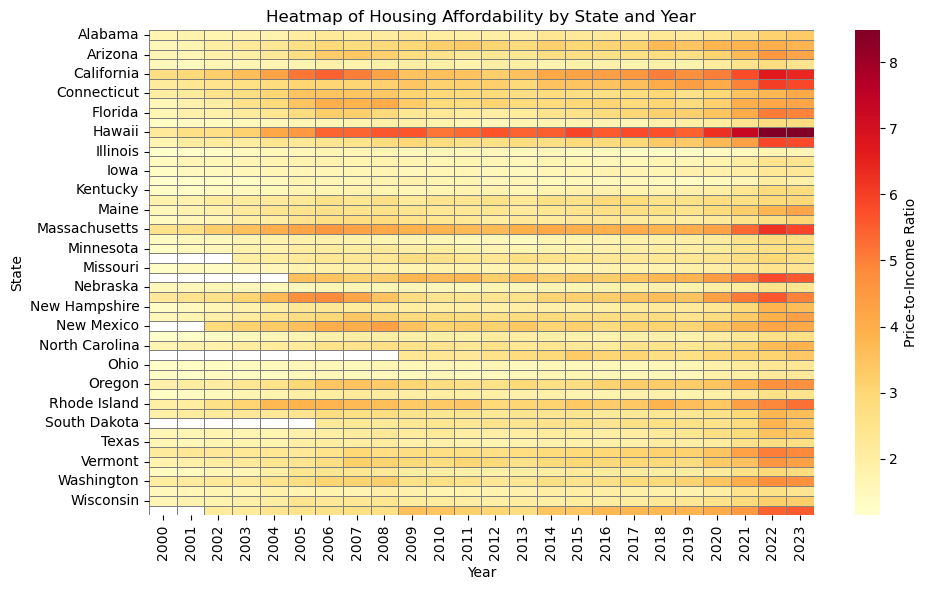

In [5]:
"""This functions adds state abbreviations and cleans the datasets by changing the format to long. It then merges the home_value and income datasets 
and calulates the price to income ratio by dividing the median house price by the median inome in each state for each year. 
Then presents the data in a heatmap showcasing affordability in each state."""
merged = all_functions.showHeatMap(home_values_dataset,income)

heatmap_data = merged.pivot(index='State', columns='Year', values='PriceToIncomeRatio')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Price-to-Income Ratio'})
plt.title("Heatmap of Housing Affordability by State and Year")
plt.xlabel("Year")
plt.ylabel("State")
plt.tight_layout()
plt.show()

### **How Have Household Income Averages Changed Over Time? A State-by-Year Comparison (2000–2023)**

This choropeth graph visualizes the average household income across all states and years. Initially states such as Minnesota, Maryland, and Alaska had average household incomes of around 84,000 and above, with some ranking lower over time (such as Minnesota and Alaska). Over the progression of time we can see that these many states show a lightening trend post-2019, reflecting a lowering in household incomes.

Note: if unable to see here a public link from plotly studio of our visualization https://chart-studio.plotly.com/~eeaguilar02/3/

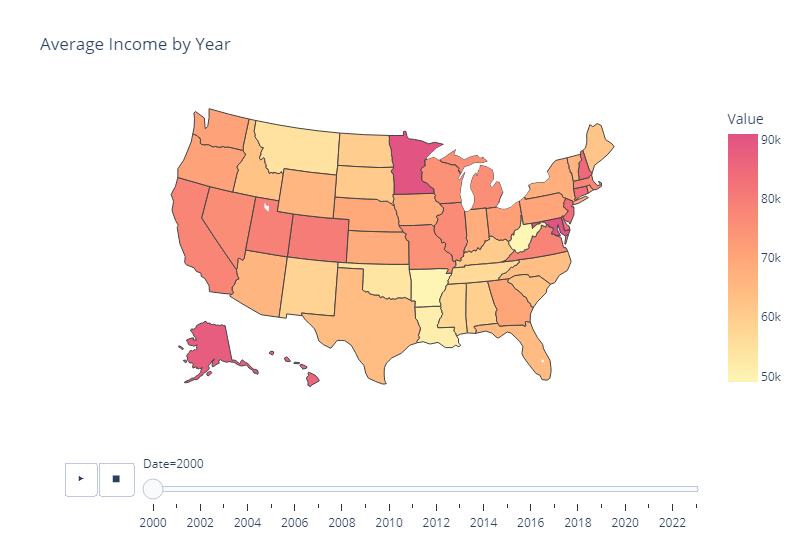

In [6]:
"""This functions adds state abbreviations and cleans the datasets by changing the format to long and drops any na values. 
It then creates a chloropath graph that animates the changes in average incomes over the years with states represented on 
their location on the United States map """

all_functions.choropleth_graph(income)

## **5. Visualization**

### Hypothesis: Housing Affordability Decline ###

We hypothesized that median household income in the United States has not increased at the same rate as median home values, making it increasingly difficult for people to afford buying a home. This seemed worth exploring because of widespread media reports and social concerns about housing affordability, especially among younger generations. To test this, We created a line chart comparing national median income and median home value from 2000 to 2023. The results clearly support the hypothesis: while incomes remained relatively flat, home values rose significantly.

### **Visualization: Diverging Trends: U.S. National Median Income vs. Home Value (2000–2023)**
This line chart compares the national median income and national median home value in the United States from 2000 to 2023. While median income has increased only modestly over the two decades, home values have risen sharply—especially after 2020. This divergence indicates a growing affordability gap, where home prices are increasing faster than people's ability to pay for them. This trend helps explain why first-time homeownership has become increasingly out of reach for many Americans.

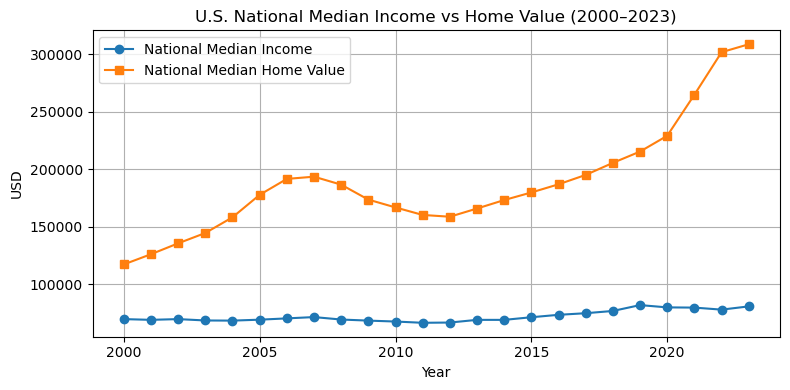

In [7]:
national_trends = merged.groupby('Year').agg({
    'MedianIncome': 'mean',
    'HomeValue': 'mean'
}).reset_index()

plt.figure(figsize=(8, 4))
plt.plot(national_trends['Year'], national_trends['MedianIncome'], label='National Median Income', marker='o')
plt.plot(national_trends['Year'], national_trends['HomeValue'], label='National Median Home Value', marker='s')
plt.title("U.S. National Median Income vs Home Value (2000–2023)")
plt.xlabel("Year")
plt.ylabel("USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **6. Machine Learning analysis**
The goal of this ML analysis is to identify patterns in affordability accross US states that are not immediately visible in raw data, and to segment states into categories with respect to their affordability.

In [8]:
state_yearly_df = all_functions.homevalues_dataset(home_values)

In [9]:
income = pd.read_csv('median_income.csv')
income = all_functions.income_dataset_ML(income)

homevalues_dataset() and income_dataset_ML() function prepares the homevalues and income data to feed into the clustering algorithm. Homevalues of all the regions of each state are averaged so that we can get one homevalue per state for each year 2000 to 2023. And in the income dataset, a separate column has been introduced for the State Codes.

### **K-Means Clustering**
Since there were no labeled outcomes or predefined affordability categories in the data, we chose unsupervised learning, specifically K-Means clustering, to let the data reveal natural groupings. K-Means is effective for partitioning data based on feature similarity and is well-suited to exploratory segmentation problems like this. To capture both current and long-term affordability trends, we used the following four features per state: Median Home Value in 2023, Home Value Growth Rate (2000–2023), Median Income in 2023, Income Growth Rate (2000–2023)

clustering() function is doing all the above mentioned processing and returning a dataframe for clustering. All features of the dataframe are normalized using standard scaling to ensure equal weighting in the clustering algorithm.

In [10]:
clustering_df = all_functions.clustering(state_yearly_df, income)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)

### BaseLine: Choosing the value of K
To determine the optimal number of clusters (K), we used the Elbow Method and Silhouette Score. We created a functtion called baseline() which dates the dataset and the range of K values we want to test as input and plots the intertia and silhouette score as output. We gave the range of K values as 2 to 10. The elbow plot showed diminishing returns after K=3, and although the silhouette score peaked at K=2, the interpretability of K=3 (high, moderate, and low affordability) aligned better with the real-world context of the problem. Therefore, K=3 was selected.

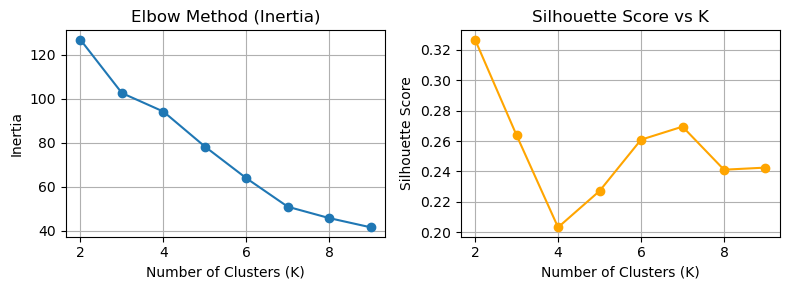

In [11]:
# Range of K values to try
all_functions.baseline(scaled_data,2,10)

In [12]:
kmeans = KMeans(n_clusters=3, random_state=42)
clustering_df['Cluster'] = kmeans.fit_predict(scaled_data)
# map cluster labels to affordability level
cluster_map = {
    0: 'Moderate Affordability',
    1: 'High Affordability',
    2: 'Low Affordability'
}
clustering_df['Affordability'] = clustering_df['Cluster'].map(cluster_map)
clustering_df.head()

,HomeValue_2023,HomeValue_Growth,Income_2023,Income_Growth,Cluster,Affordability
StateName,,,,,,
NY,217244.254634,177.663556,81600.0,20.088300,1,High Affordability
CA,593357.691233,203.980242,89870.0,15.114641,2,Low Affordability
IL,148540.889778,43.330029,87820.0,14.319188,0,Moderate Affordability
TX,216411.865369,87.296005,79060.0,22.783041,1,High Affordability
VA,270847.217093,122.690736,96490.0,22.682772,1,High Affordability


### Results & Interpretation
The clustering grouped states into three affordability tiers. States like Texas, Iowa, and Mississippi were clustered as high affordability, while California, Hawaii were identified as low affordability. Some states formed a moderate affordability group. These clusters are visualized on a U.S. map using color-coded choropleth shading, clearly showing regional patterns in affordability. 

Note: if unable to see here a public link from plotly studio of our visualizationhttps://chart-studio.plotly.com/~eeaguilar02/6/

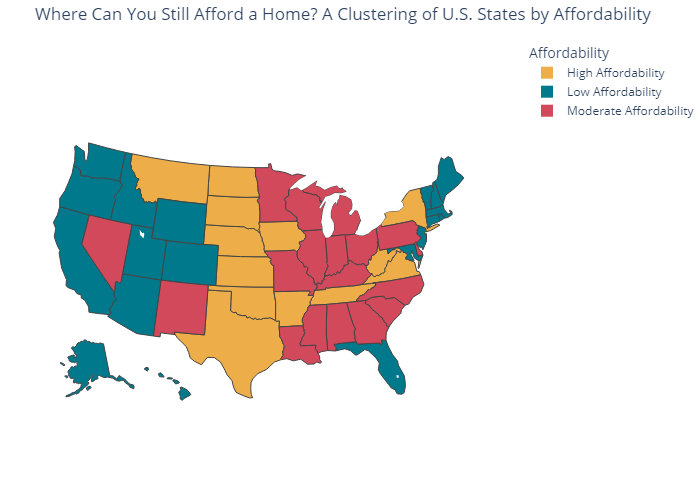

In [13]:
all_functions.showClustersInMap(clustering_df)

## **Where Can You Still Afford a Home? A Clustering of U.S. States by Affordability**
This map shows the results of a K-Means clustering analysis that grouped U.S. states into three categories based on housing affordability: high, moderate, or low affordability based on the relationship between rising home prices and income levels. High Affordable states tend to have relatively low home values and/or healthy income growth, making it easier for residents to afford homes. Many of these are in the central and mountain regions, such as Montana, Texas, and Maine. 
Moderate Affordabile states fall somewhere in the middle — either with moderate home values and income, or a balance of high values with strong income growth. This group includes a mix of Midwestern and Southern states like Tennessee, Michigan, and Pennsylvania.
Low Affordabile states are where home prices have significantly outpaced income growth, making housing much harder to afford. These include coastal states like California, Florida, which are known for high cost-of-living pressures.

The map visually confirms a growing affordability divide in the U.S., with coastal and southern states generally showing lower affordability, while some interior and less densely populated states remain more accessible for homebuyers. The clustering offers a data-driven lens to understand how economic and housing market trends are shaping access to homeownership nationwide.

## **7. Reflection: a discussion of the following:**
**o What is hardest part of the project that you’ve encountered so far?**
- Cleaning and aligning the datasets was challenging due to different formats and time scales.
- Selecting a machine learning method that fit our problem took thoughtful consideration.
- Applying clustering required careful feature selection and data scaling.
- Interpreting and validating the clusters made the ML component the most demanding part of the project.
  
**o What are your initial insights?**
- Average home prices are much higher than incomes in all states, especially in places like HI, CA, and MA, standing out as the least affordable.
- Since 2020, prices have surged while income growth stayed modest, widening the affordability gap.
- These patterns confirm that rising income alone is not enough to improve housing affordability, especially in high cost regions.
  
**o Are there any concrete results you can show at this point? If not, why not?**
- Yes, We cleaned and merged income and home value data to calculate price-to-income ratios.
- A heatmap of affordability by state and year, showing where affordability has worsened
- KMeans clustering grouped states into affordability categories, uncovering patterns beyond basic averages.
  
**o Going forward, what are the current biggest problems you’re facing?**
- Our current model is limited in scope — it only uses income and year. While it performs better than a baseline, its predictive power could be stronger with more variables (e.g., mortgage rates, population growth, construction rates)
- Currently it would most likely be making the 2nd machine learning to analyze the data, and making sure the first ML is adequate. Visualizations are effective but need polishing for presentation
  
**o Do you think you are on track with your project? If not, what parts do you need to dedicate more time to?**
- Yes, We've completed the major parts of cleaning, merging, visualizing, and modeling
- What remains is improving the visual design, summarizing & explaining findings, and wrapping the project into a clean presentation or report. Make 1 more ML,figure out 2 final and distinct visual results, picking one extra from either category ML or Visualization.
  
**o Given your initial exploration of the data, is it worth proceeding with yourproject, why? If not, how are you going to change your project and why do you think it’s better than your current results?**
Absolutely. The trends are real, the results are meaningful, and the topic is highly relevant. The insights can help homebuyers, policymakers, and researchers understand the housing affordability crisis from a data-driven perspective.

## **8. Next steps:**
In the next month, we plan to finalize our visualizations, write up our results, optionally test a more advanced machine learning model, and prepare our final presentation or paper; we’ll evaluate success based on how clearly we show affordability trends, the performance of our model, the clarity of our visual explanations, and how well our findings support the original hypothesis.

Link to the Jupyter Notebook file: 
Link to the all_functions file: https://github.com/uic-cs418/group-project-stat-squad/blob/main/all_functions.py